In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### Imports

In [1]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
%matplotlib inline

from tensorflow.keras import backend as K # Importing Keras backend (by default it is Tensorflow)
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, Flatten, MaxPool2D # Layers to be used for building our model
from tensorflow.keras.models import Model # The class used to create a model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.random import set_seed

print("Tensorflow version " + tf.__version__)

ModuleNotFoundError: No module named 'tensorflow'

### Data manipulation

**Task**: Given an image of handwritten digit find the digit

**Data**:
- The data are grayscale 28*28 images of scanned handwritten digits
- We will use an MLP to classify them so we first need to flatten them
- The values of the inputs are in [0, 255] so we normalize them to [0, 1]

In [3]:
batch_size = 128
classes = 10
epochs = 100

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
Y_train = to_categorical(y_train, classes)
Y_test = to_categorical(y_test, classes)

11490434/11490434 [==============================] - 1s 0us/step


### Plotting results

In [4]:
def plot_history(hs, epochs, metric):
    print()
    plt.style.use('dark_background')
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='loss' else 'Accuracy')
    plt.legend()
    plt.show()


### Cleaning up

In [5]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()


### Model creation

- We will use a Functional Model.
    - It is more flexible than the `Sequential` model but ...
    - We need to be careful with the sizes of the layers.
- The first layer should always be an `Input` layer where we specify the input of the model, e.g., the training data
- The other layers can be whatever we want and for each layer we must:
    - Define the input to the layer, i.e., another layer.
    - Define the number of units which also defines the output size.
        - The output size must be always equal to the number of units of the next layer.


In [6]:
def train_model(
        train_data,
        train_labels,
        optimizer,
        epochs=100,
        batch_size=128,
        hidden_layers=0,
        hidden_activation='relu',
        output_activation='softmax',
        verbose=0):
    
    np.random.seed(1402) # Define the seed for numpy to have reproducible experiments.
    set_seed(1981) # Define the seed for Tensorflow to have reproducible experiments.
    
    # Define the input layer.
    input = Input(
        shape=(784,),
        name='Input'
    )

    x = input
    # Define the remaining hidden layers.
    for i in range(hidden_layers):
        x = Dense(
            units=256,
            kernel_initializer='glorot_uniform',
            activation=hidden_activation,
            name='Hidden-{0:d}'.format(i + 1)
        )(x)
        
    # Define the output layer.
    output = Dense(
        units=classes,
        kernel_initializer='glorot_uniform',
        activation=output_activation,
        name='Output'
    )(x)

    # Define the model and train it.
    model = Model(inputs=input, outputs=output)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    hs = model.fit(
        x=X_train,
        y=Y_train,
        validation_split=0.1, # use 10% of the training data as validation data
        epochs=epochs,
        verbose=verbose,
        batch_size=batch_size
    )
    print('Finished training.')
    print('------------------')
    model.summary() # Print a description of the model.
    return model, hs


### Using SGD

In [7]:
# Using SGD
optimizer = SGD(learning_rate=0.01)

# Logistic Regression
lr_model_sgd, lr_hs_sgd = train_model(
    train_data=X_train,
    train_labels=Y_train,
    optimizer=optimizer,
    epochs=epochs,
    batch_size=batch_size,
    hidden_layers=0,
    hidden_activation='relu',
    output_activation='softmax'
)

# Evaluate on test data and show all the results.
lr_eval_sgd = lr_model_sgd.evaluate(X_test, Y_test, verbose=1)
clean_up(model=lr_model_sgd)

Finished training.
------------------
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 784)]             0         
                                                                 
 Output (Dense)              (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
313/313 [==============================] - 1s 3ms/step - loss: 0.2848 - accuracy: 0.9205


### Logistic Regression results

Train Loss     : 0.29452
Validation Loss: 0.24839
Test Loss      : 0.28483
---
Train Accuracy     : 0.91787
Validation Accuracy: 0.93133
Test Accuracy      : 0.92050



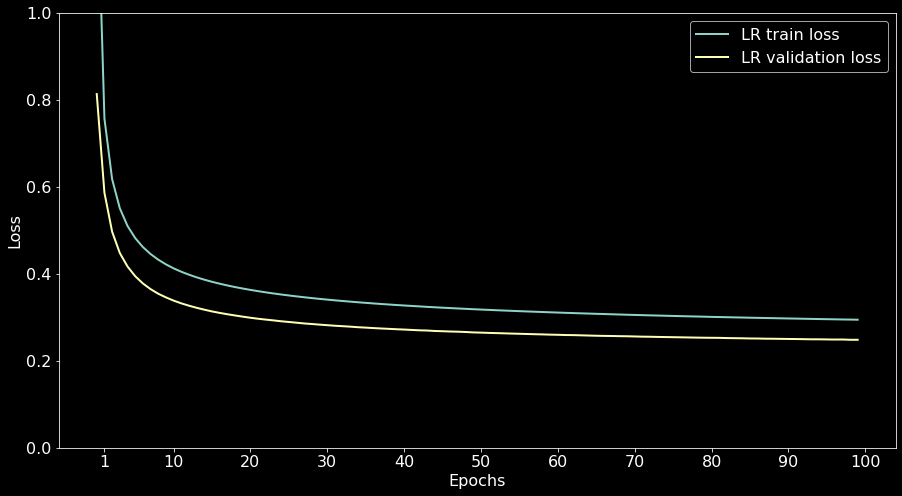

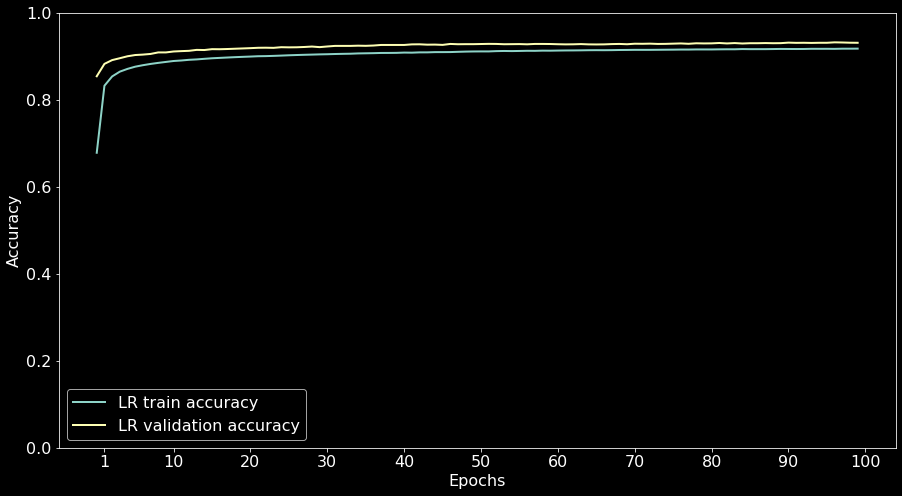

In [8]:
print("Train Loss     : {0:.5f}".format(lr_hs_sgd.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(lr_hs_sgd.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(lr_eval_sgd[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(lr_hs_sgd.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(lr_hs_sgd.history['val_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(lr_eval_sgd[1]))

# Plot train and validation error per epoch.
plot_history(hs={'LR': lr_hs_sgd}, epochs=epochs, metric='loss')
plot_history(hs={'LR': lr_hs_sgd}, epochs=epochs, metric='accuracy')

In [9]:
# Using SGD
optimizer = SGD(learning_rate=0.01)

# MLP
mlp_model_sgd, mlp_hs_sgd = train_model(
    train_data=X_train,
    train_labels=Y_train,
    optimizer=optimizer,
    epochs=epochs,
    batch_size=batch_size,
    hidden_layers=1,
    hidden_activation='relu',
    output_activation='softmax'
)

# Evaluate on test data and show all the results.
mlp_eval_sgd = mlp_model_sgd.evaluate(X_test, Y_test, verbose=1)
clean_up(model=mlp_model_sgd)

Finished training.
------------------
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 784)]             0         
                                                                 
 Hidden-1 (Dense)            (None, 256)               200960    
                                                                 
 Output (Dense)              (None, 10)                2570      
                                                                 
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________
313/313 [==============================] - 1s 3ms/step - loss: 0.0991 - accuracy: 0.9705


### Logistic Regression vs. MLP results

Train Loss     : 0.08459
Validation Loss: 0.09049
Test Loss      : 0.09908
---
Train Accuracy     : 0.97770
Validation Accuracy: 0.97500
Test Accuracy      : 0.97050



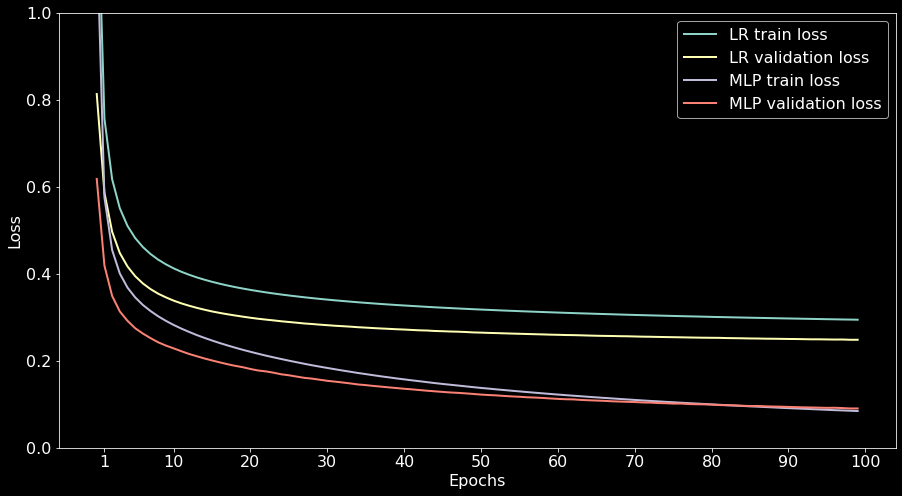

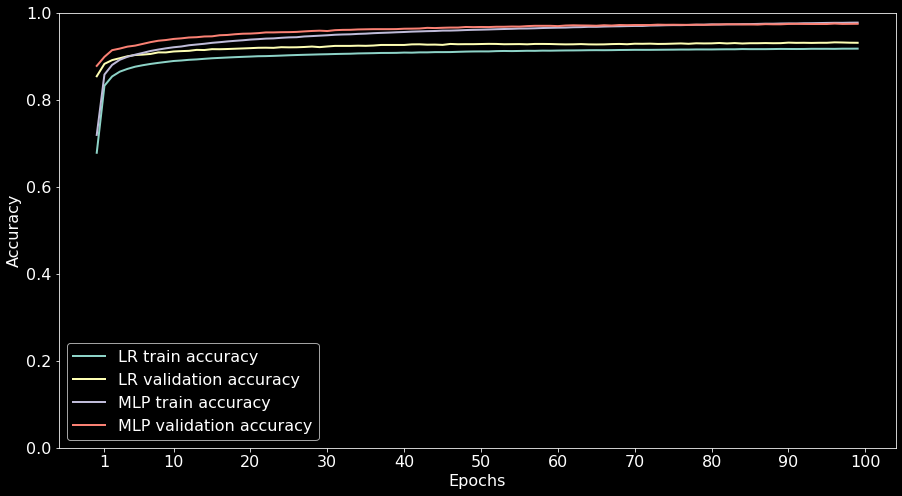

In [10]:
print("Train Loss     : {0:.5f}".format(mlp_hs_sgd.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(mlp_hs_sgd.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(mlp_eval_sgd[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(mlp_hs_sgd.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(mlp_hs_sgd.history['val_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(mlp_eval_sgd[1]))

# Plot train and validation error per epoch.
plot_history(hs={'LR': lr_hs_sgd, 'MLP': mlp_hs_sgd}, epochs=epochs, metric='loss')
plot_history(hs={'LR': lr_hs_sgd, 'MLP': mlp_hs_sgd}, epochs=epochs, metric='accuracy')

### Using Adam

In [11]:
# Using Adam
optimizer = Adam()

# Logistic Regression
lr_model_adam, lr_hs_adam = train_model(
    train_data=X_train,
    train_labels=Y_train,
    optimizer=optimizer,
    epochs=epochs,
    batch_size=batch_size,
    hidden_layers=0,
    hidden_activation='relu',
    output_activation='softmax'
)

# Evaluate on test data and show all the results.
lr_eval_adam = lr_model_adam.evaluate(X_test, Y_test, verbose=1)
clean_up(model=lr_model_adam)

Finished training.
------------------
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 784)]             0         
                                                                 
 Output (Dense)              (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
313/313 [==============================] - 1s 2ms/step - loss: 0.2784 - accuracy: 0.9274


### Logistic Regression results

Train Loss     : 0.22595
Validation Loss: 0.23502
Test Loss      : 0.27843
---
Train Accuracy     : 0.93752
Validation Accuracy: 0.93683
Test Accuracy      : 0.92740



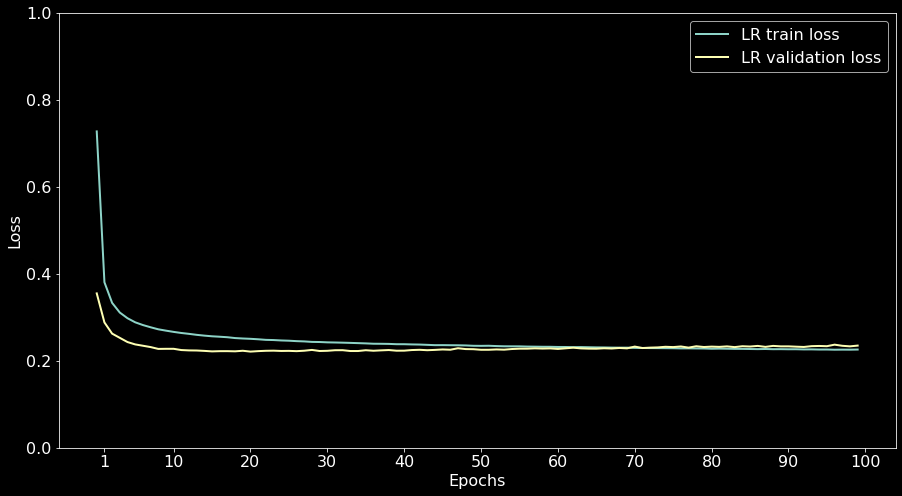

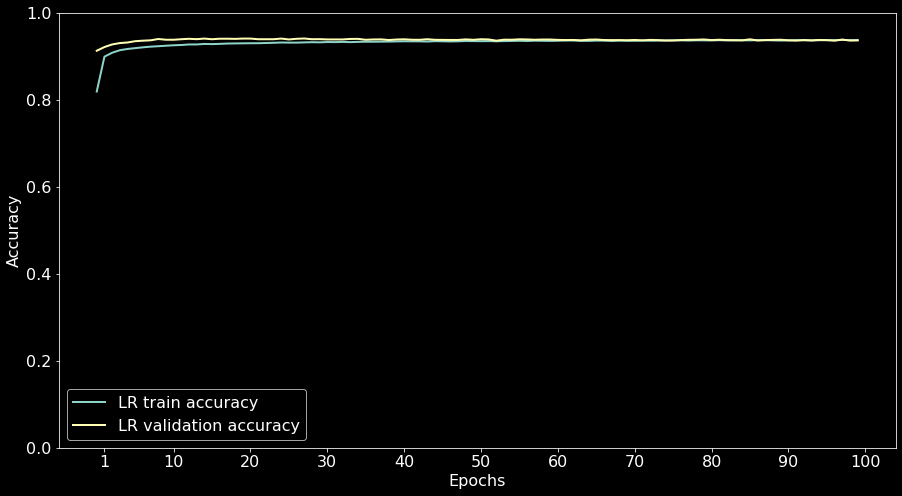

In [12]:
print("Train Loss     : {0:.5f}".format(lr_hs_adam.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(lr_hs_adam.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(lr_eval_adam[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(lr_hs_adam.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(lr_hs_adam.history['val_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(lr_eval_adam[1]))

# Plot train and validation error per epoch.
plot_history(hs={'LR': lr_hs_adam}, epochs=epochs, metric='loss')
plot_history(hs={'LR': lr_hs_adam}, epochs=epochs, metric='accuracy')

In [13]:
# Using Adam
optimizer = Adam()

# MLP
mlp_model_adam, mlp_hs_adam = train_model(
    train_data=X_train,
    train_labels=Y_train,
    optimizer=optimizer,
    epochs=epochs,
    batch_size=batch_size,
    hidden_layers=1,
    hidden_activation='relu',
    output_activation='softmax'
)

# Evaluate on test data and show all the results.
mlp_eval_adam = mlp_model_adam.evaluate(X_test, Y_test, verbose=1)
clean_up(model=mlp_model_adam)

Finished training.
------------------
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 784)]             0         
                                                                 
 Hidden-1 (Dense)            (None, 256)               200960    
                                                                 
 Output (Dense)              (None, 10)                2570      
                                                                 
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________
313/313 [==============================] - 1s 4ms/step - loss: 0.1054 - accuracy: 0.9837


### Logistic Regression vs. MLP results

Train Loss     : 0.00001
Validation Loss: 0.12072
Test Loss      : 0.10542
---
Train Accuracy     : 1.00000
Validation Accuracy: 0.98433
Test Accuracy      : 0.98370



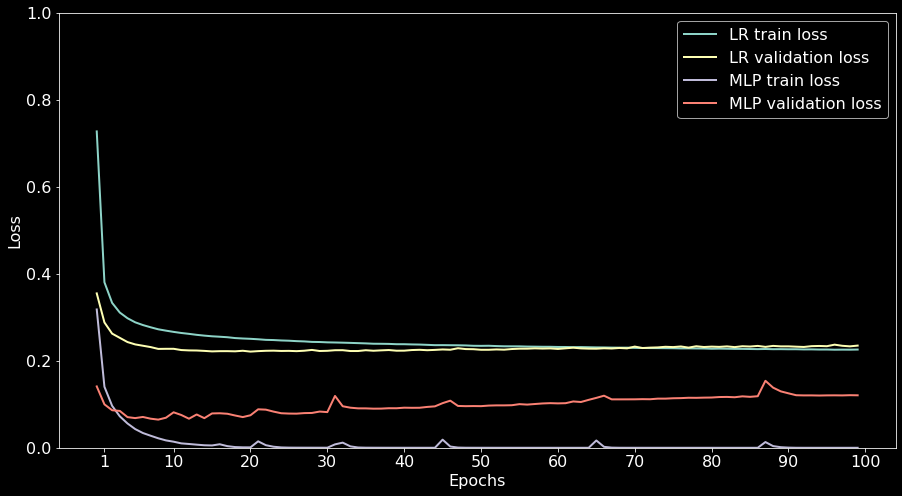

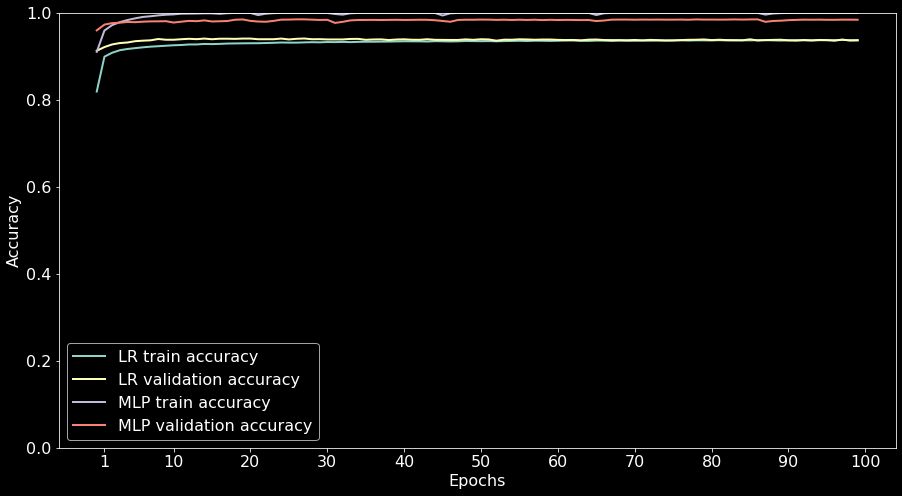

In [14]:
print("Train Loss     : {0:.5f}".format(mlp_hs_adam.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(mlp_hs_adam.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(mlp_eval_adam[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(mlp_hs_adam.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(mlp_hs_adam.history['val_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(mlp_eval_adam[1]))


# Plot train and validation error per epoch.
plot_history(hs={'LR': lr_hs_adam, 'MLP': mlp_hs_adam}, epochs=epochs, metric='loss')
plot_history(hs={'LR': lr_hs_adam, 'MLP': mlp_hs_adam}, epochs=epochs, metric='accuracy')

In [ ]:
exit()